# UCF 101 Action Recognition

The purpose of the notebook for UCF 101 (University of Central Florida 101 dataset) is typically focused on action recognition in videos. UCF 101 is a popular dataset used in computer vision and deep learning research to train and evaluate models for recognizing human actions in video clips. The dataset consists of 101 action categories such as "basketball," "running," "clapping," and many others, with video clips taken from various sources like movies, TV shows, and YouTube.

In a notebook using UCF 101, the main goal could be:

Data Preprocessing: Loading, preprocessing, and augmenting the video data (such as resizing, normalization, and transforming the video frames).

Model Training: Using deep learning models, such as CNNs (Convolutional Neural Networks), RNNs (Recurrent Neural Networks), or 3D CNNs to learn the spatial and temporal features from the videos.

Action Classification: Training models to classify the actions in the UCF 101 videos based on the visual features extracted from the frames.

Evaluation and Performance Metrics: Testing the model on the dataset, using performance metrics like accuracy, precision, recall, and F1 score to evaluate how well the model is recognizing actions.

Application: Demonstrating how the model can be applied to recognize human actions in new, unseen video data, potentially in real-world applications like surveillance, video tagging, and human-computer interaction.

In [5]:
import tensorflow as tf

In [6]:
!nvidia-smi

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Sat Nov  9 10:31:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))



physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:

    tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available:  1


In [8]:
import os

import cv2

import math

import random

import numpy as np

import datetime as dt

import tensorflow as tf

from collections import deque

import matplotlib.pyplot as plt



# from moviepy.editor import *

%matplotlib inline



from sklearn.model_selection import train_test_split

import pandas as pd

from tensorflow.keras.layers import *

from tensorflow.keras.models import Sequential

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.utils import plot_model






# DATASET INSIGHTS

UCF101 dataset is an extension of UCF50 and consists of 13,320 video clips, which are classified into 101 categories. These 101 categories can be classified into 5 types (Body motion, Human-human interactions, Human-object interactions, Playing musical instruments and Sports). The total length of these video clips is over 27 hours. All the videos are collected from YouTube and have a fixed frame rate of 25 FPS with the resolution of 320 × 240.



UCF 50



50 Action Categories



25 Groups of Videos per Action Category



133 Average Videos per Action Category



199 Average Number of Frames per Video



320 Average Frames Width per Video



240 Average Frames Height per Video



26 Average Frames Per Seconds per Video

# VISUALISATION

In [9]:
DATASET_PATH = "/kaggle/input/ucf101-action-recognition/"

TRAIN_DIR = '/kaggle/input/ucf101-action-recognition/train'
VAL_DIR = '/kaggle/input/ucf101-action-recognition/va;'
TEST_DIR = '/kaggle/input/ucf101-action-recognition/test'

TRAIN_CSV = '/kaggle/input/ucf101-action-recognition/train.csv'
VAL_CSV = '/kaggle/input/ucf101-action-recognition/val.csv'
TEST_CSV = '/kaggle/input/ucf101-action-recognition/test.csv'

In [10]:
# Load csv files
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

In [11]:
# View first 10 rows of train_df
train_df.head(10)

,clip_name,clip_path,label
0,v_Swing_g05_c02,/train/Swing/v_Swing_g05_c02.avi,Swing
1,v_Swing_g21_c03,/train/Swing/v_Swing_g21_c03.avi,Swing
2,v_Swing_g07_c01,/train/Swing/v_Swing_g07_c01.avi,Swing
3,v_Swing_g24_c04,/train/Swing/v_Swing_g24_c04.avi,Swing
4,v_Swing_g20_c03,/train/Swing/v_Swing_g20_c03.avi,Swing
5,v_Swing_g12_c04,/train/Swing/v_Swing_g12_c04.avi,Swing
6,v_Swing_g04_c01,/train/Swing/v_Swing_g04_c01.avi,Swing
7,v_Swing_g21_c01,/train/Swing/v_Swing_g21_c01.avi,Swing
8,v_Swing_g25_c01,/train/Swing/v_Swing_g25_c01.avi,Swing
9,v_Swing_g02_c02,/train/Swing/v_Swing_g02_c02.avi,Swing


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


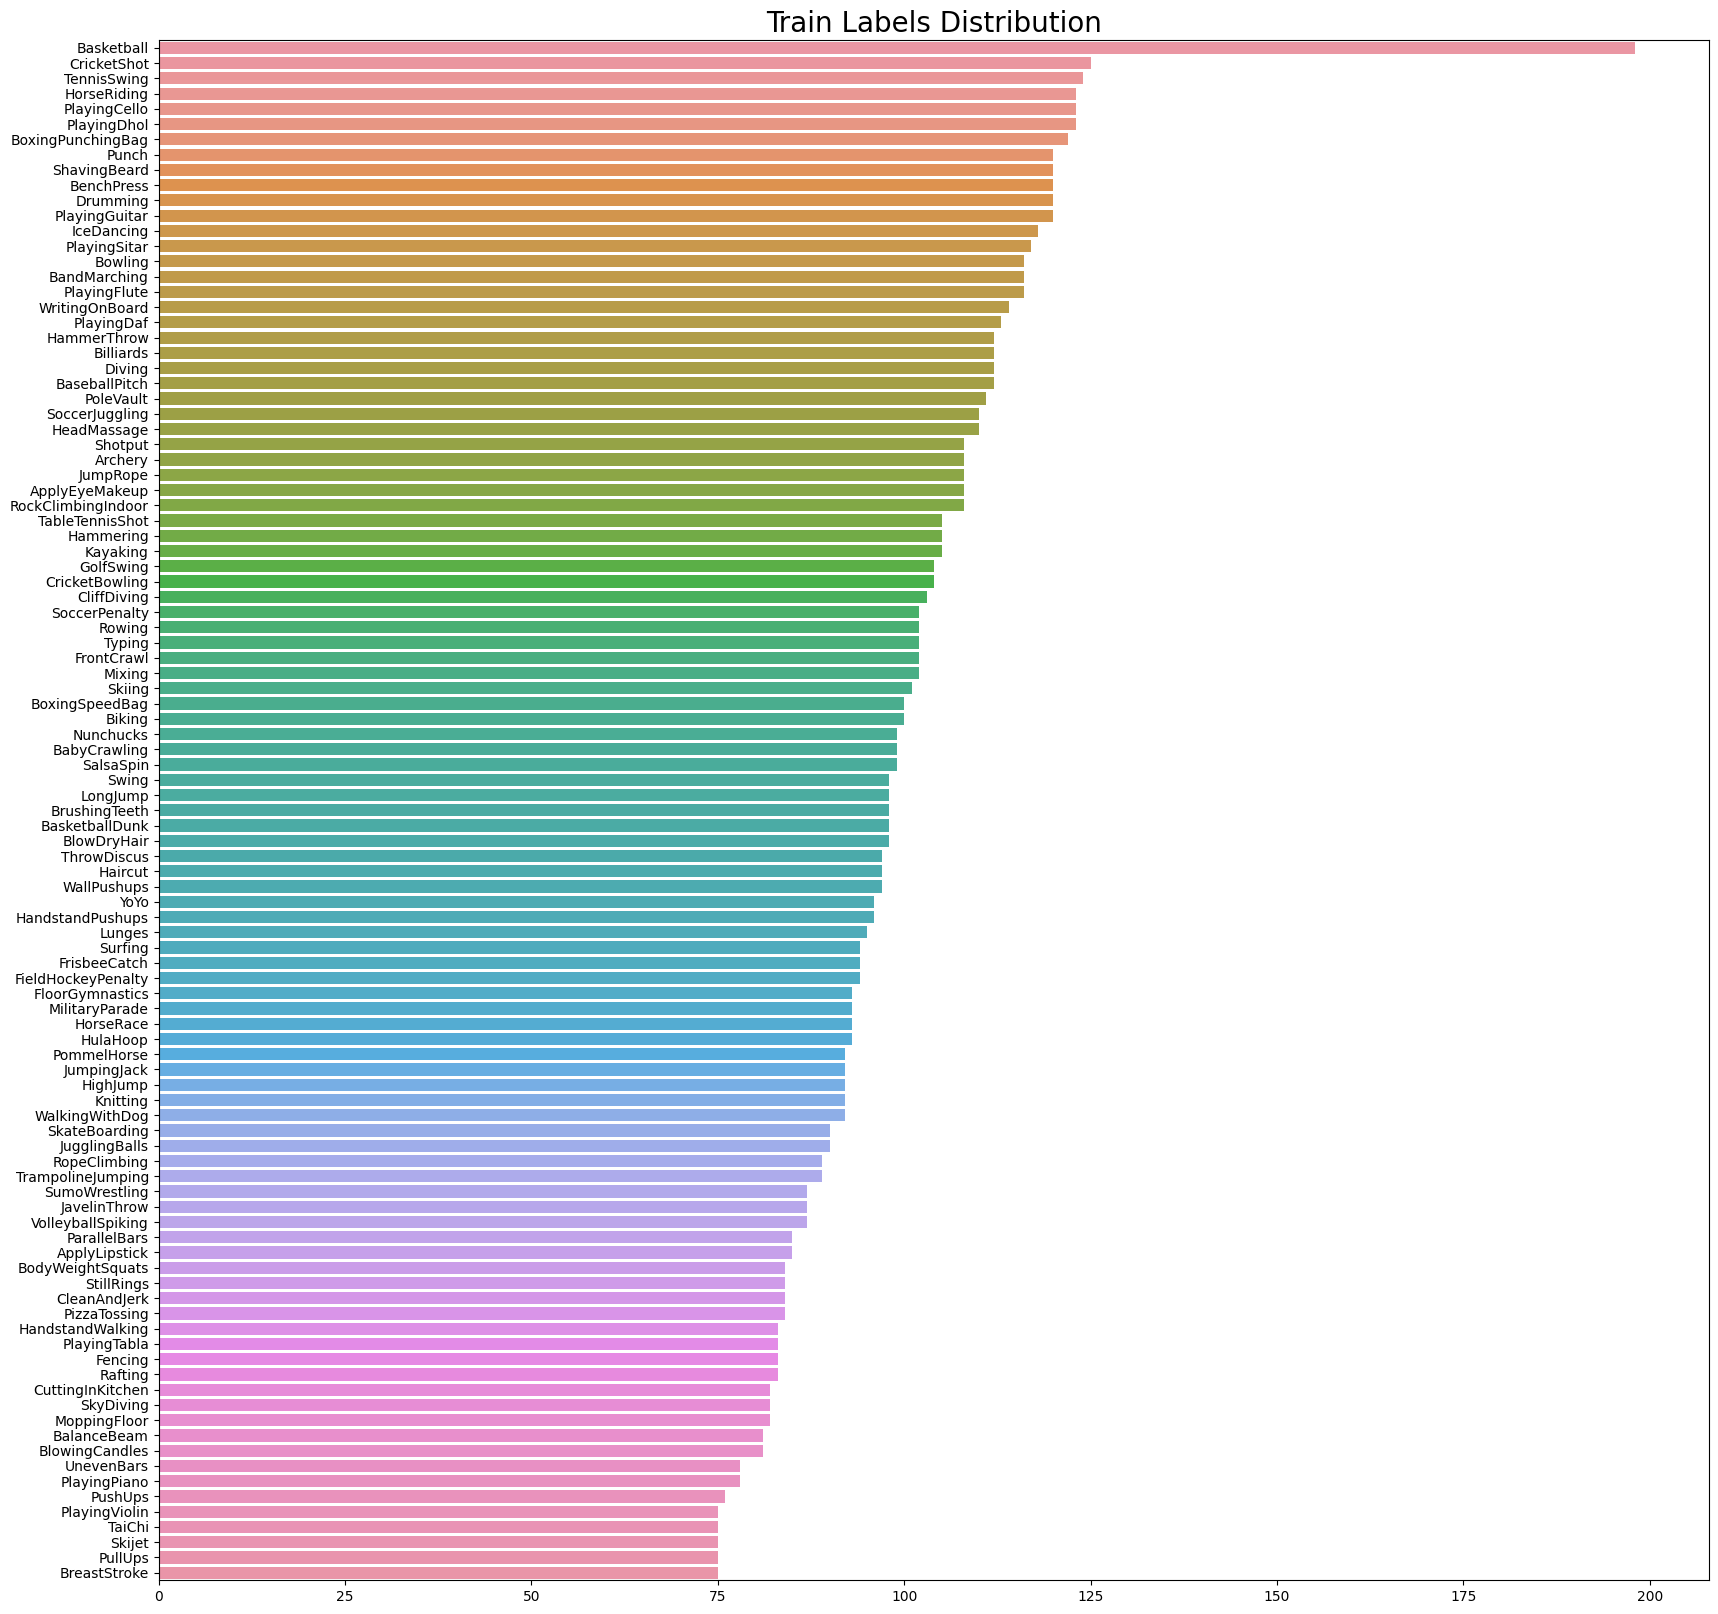

In [12]:
import seaborn as sns
# View Label Distibutions
plt.figure(figsize=(20, 20))
plt.title('Train Labels Distribution', fontsize=20)
label_distribution = train_df['label'].value_counts()

sns.barplot(x=label_distribution.values,
            y=list(label_distribution.keys()),
            orient="h");

In [31]:
IMAGE_HEIGHT,IMAGE_WIDTH = 64,64

SEQUENCE_LENGTH = 20



CLASSES_LIST=["PlayingTabla","PommelHorse","JumpingJack","PushUps","PoleVault","HorseRace","HighJump","Drumming","HorseRiding","Diving","BreastStroke",

              "Basketball","TrampolineJumping","YoYo","SalsaSpin","WalkingWithDog","VolleyballSpiking","ThrowDiscus","TennisSwing","TaiChi","Swing",

              "SoccerJuggling","Skijet","Skiing","SkateBoarding","Rowing","RopeClimbing","RockClimbingIndoor","Punch","PullUps","PlayingViolin","PlayingPiano","PlayingGuitar",

              "PizzaTossing","Nunchucks","Mixing","MilitaryParade","Lunges","Kayaking","JumpRope","JugglingBalls","JavelinThrow","HulaHoop","GolfSwing","Fencing",

              "CleanAndJerk","Billiards","Biking","BenchPress","BaseballPitch"]


# VIDEO PREPROCESSING

In [32]:

def frames_extraction(video_path):
    frames_list = []
    
    # Initialize video reader and check if it's opened successfully
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return None

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)  # Default skip is 1 if SEQUENCE_LENGTH > frame count

    for frame_counter in range(SEQUENCE_LENGTH):
        # Set position to the desired frame
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            print(f"Warning: Could not read frame {frame_counter} in {video_path}")
            break

        # Resize and normalize the frame
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_list.append(normalized_frame)

    # Release the video capture object
    video_reader.release()

    # Check if we have the expected number of frames
    if len(frames_list) == SEQUENCE_LENGTH:
        return frames_list
    else:
        print(f"Warning: Extracted only {len(frames_list)} frames from {video_path}. Expected {SEQUENCE_LENGTH}.")
        return None


In [34]:
import os
import numpy as np

def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    #for class_index, class_name in enumerate(CLASSES_LIST[:40]):
    for class_index, class_name in enumerate(CLASSES_LIST[:4]):  # Changed from [:40] to [:4]

        print(f'Extracting Data of Class: {class_name}')

        # Define the path to the class directory
        class_path = os.path.join(TRAIN_DIR, class_name)
        #print(class_path)
        
        # Check if the directory exists
        if not os.path.exists(class_path):
            print(f"Directory {class_name} not found, skipping...")
            continue

        files_list = os.listdir(class_path)

        for file_name in files_list:
            video_file_path = os.path.join(class_path, file_name)

            try:
                # Extract frames from the video
                frames = frames_extraction(video_file_path)

                # Only add the data if the frames match SEQUENCE_LENGTH
                if len(frames) == SEQUENCE_LENGTH:
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)

            except Exception as e:
                print(f"Error processing file {file_name} in {class_name}: {e}")

    # Convert lists to numpy arrays for compatibility with ML models
    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths


# FEATURE EXTRACTION

In [35]:
features,labels,video_files_paths = create_dataset()

Extracting Data of Class: PlayingTabla
Extracting Data of Class: PommelHorse
Extracting Data of Class: JumpingJack
Extracting Data of Class: PushUps


In [36]:
print(f"Number of labels: {len(labels)}")

Number of labels: 343


In [42]:
#one_hot_encoded_labels = to_categorical(labels, num_classes=40)
one_hot_encoded_labels = to_categorical(labels, num_classes=4)

In [43]:
seed_constant = 27

np.random.seed(seed_constant)

random.seed(seed_constant)

tf.random.set_seed(seed_constant)

# SPLITTING DATA FOR TRAIN TEST

In [44]:
features_train,features_test,labels_train,lables_test = train_test_split(features,one_hot_encoded_labels,

                                                                         test_size = 0.25,shuffle = True,

                                                                         random_state = seed_constant)

# CNN-LSTM MODEL LAYERS



LRCN is often applied in scenarios where both spatial and temporal information are crucial for accurate action recognition, such as recognizing complex actions in videos.

ConvLSTM is well-suited for tasks where understanding the spatial evolution of features is essential, such as tracking and recognizing objects in motion.





LRCN combines CNNs for spatial feature extraction with RNNs for temporal modeling.

ConvLSTM integrates convolutional operations directly into the LSTM cells, allowing it to capture spatial dependencies within the temporal context.

In [45]:
SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH

(20, 64, 64)

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, TimeDistributed, Dense, Flatten, LSTM
from tensorflow.keras.layers import MaxPooling2D, Dropout


def create_LRCN_model():





    model = Sequential()



    #Model Architecture.

    #---------------------------------------------------------------------------------------------------------------------------------------------------#



    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),

                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))



    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Dropout(0.25)))



    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Dropout(0.25)))



    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))

    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Dropout(0.25)))



    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))

    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    #model.add(TimeDistributed(Dropout(0.25)))



    model.add(TimeDistributed(Flatten()))



    #K-LAYERED LSTM K=1

    model.add(LSTM(32))



    model.add(Dense(4, activation = 'softmax'))



    #------------------------------------------------------------------------------------------------------------------------------------------------#



    model.summary()





    return model

1. Number of Layers: The choice of the number of convolutional and pooling layers in the TimeDistributed layers is based on a common architecture pattern for extracting spatial features from video frames, increasing the number of filters while reducing spatial dimensions to capture hierarchical features.



2. Activation Function: ReLU (Rectified Linear Unit) activation functions was chosen for convolutional layers because to introduce non-linearity to the model, allowing it to learn complex patterns in the data effectively.



3. Dropout: Dropout layers with a dropout rate of 0.25 was added after each MaxPooling2D layer to prevent overfitting by randomly deactivating a fraction of neurons during training.



4. LSTM Layer: A single LSTM layer with 32 units was chosen to capture temporal dependencies in the video sequences.



5. Output Layer Activation: The softmax activation function was used in the output layer to convert the model's predictions into class probabilities, suitable for multi-class classification tasks.

In [47]:


LRCN_model = create_LRCN_model()





print("Model Created Successfully!")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_12             │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


# MODEL PLOT VISUALISATION

In [48]:
!pip install pydot

!pip install graphviz

import pydot

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


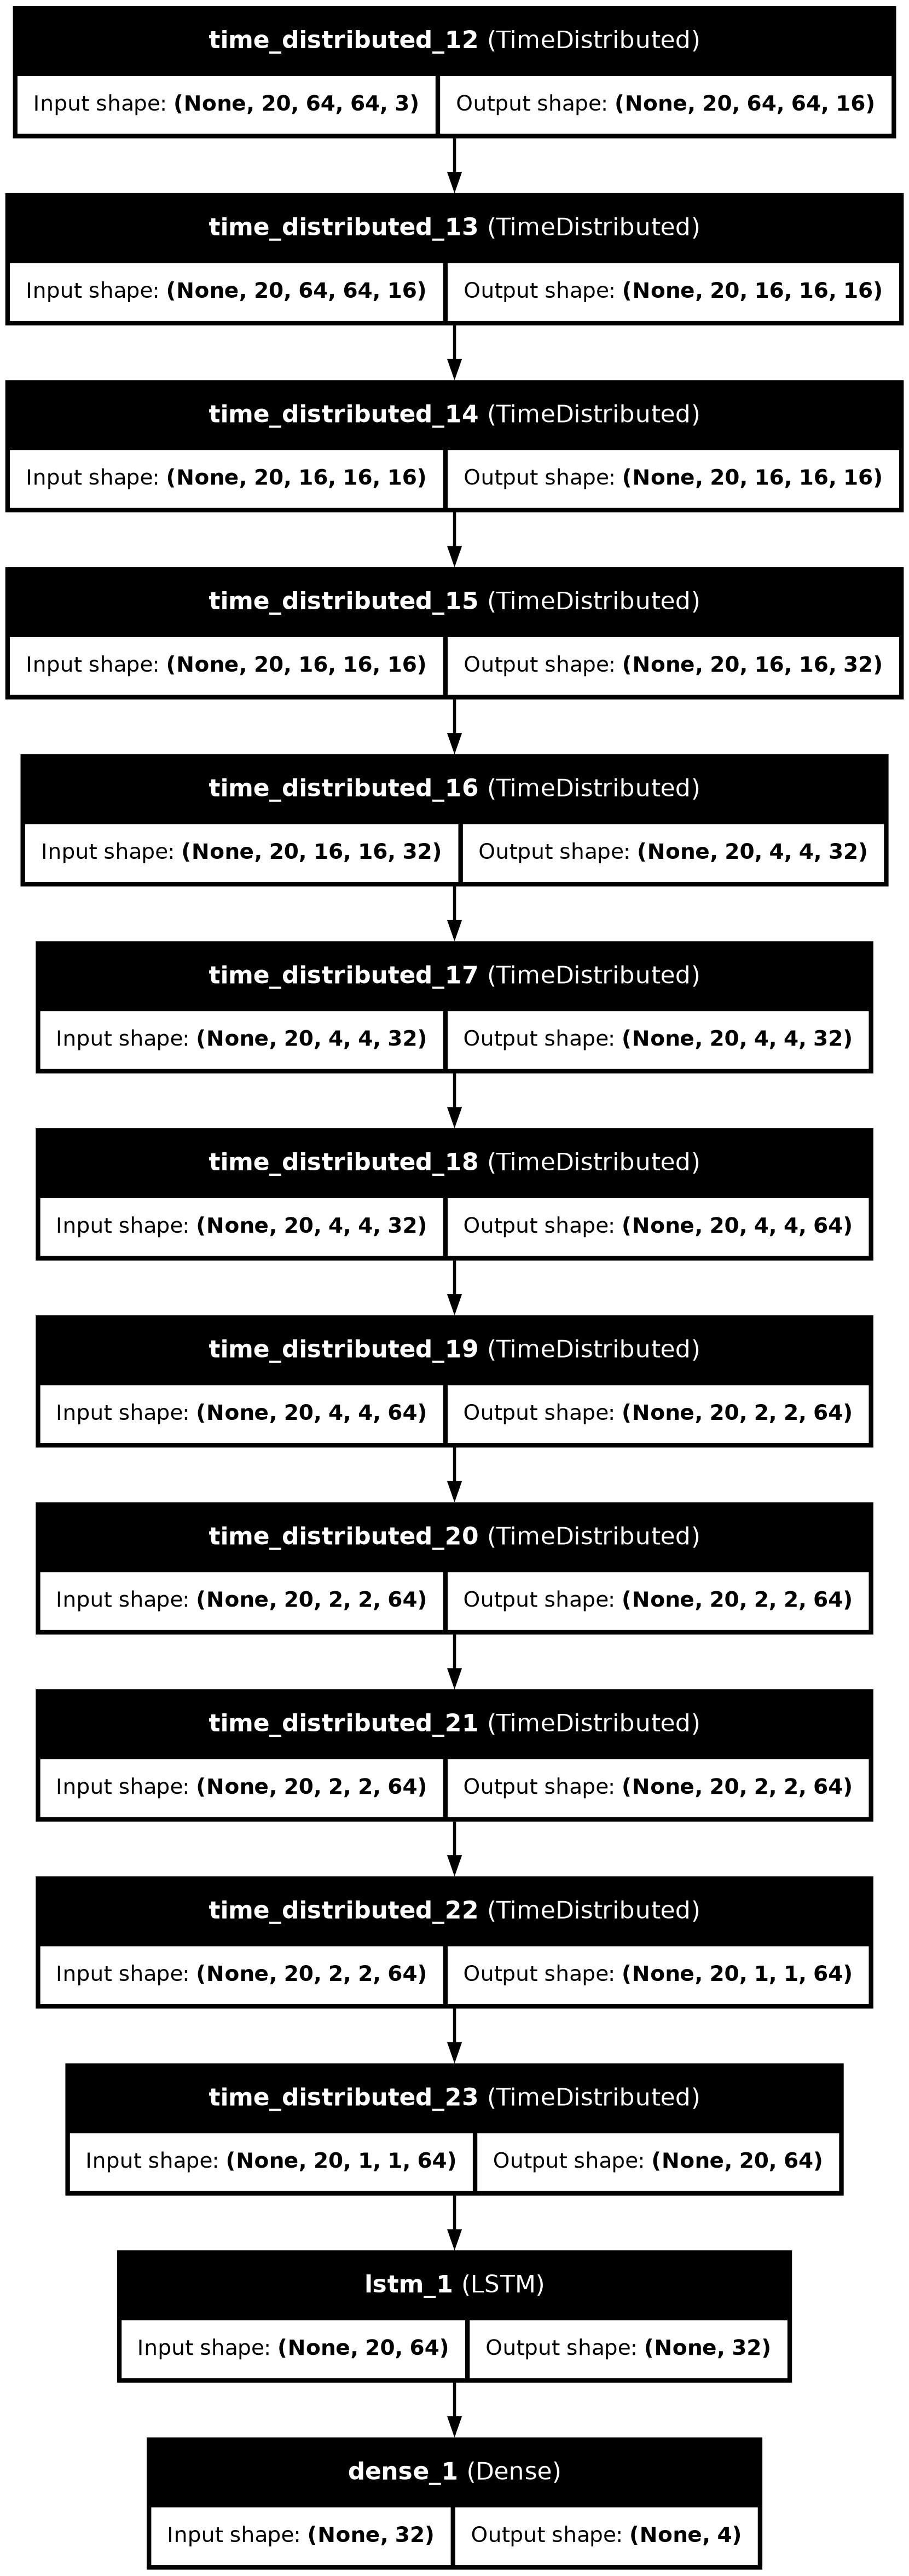

In [50]:
plot_model(LRCN_model,to_file = 'LRCN_model_Structure_plot.png',show_shapes=True,show_layer_names = True)

In [51]:
def plot_metric(model_training_history,metric_name1,metric_name2,plot_name):

  metric_value1 = model_training_history.history[metric_name1]

  metric_value2 = model_training_history.history[metric_name2]



  epochs = range(len(metric_value1))



  plt.plot(epochs,metric_value1,'blue',label=metric_name1)

  plt.plot(epochs,metric_value2,'red',label=metric_name2)

  plt.title(str(plot_name))



  plt.legend()

# MODEL TRAINING

1. Learning Rate: The choice of the learning rate (lr),a value of 0.001 (default value for Adam optimizer)  model to converge effectively without causing divergence.



2. Optimizer: The Adam optimizer was chosen because it combines the benefits of both AdaGrad and RMSProp, providing effective optimization for training.



3. Epochs: The number of epochs (100) was selected based on early stopping to prevent overfitting while allowing the model to train until convergence.



4. Batch Size: A batch size of 4 was chosen to have a balance between computation efficiency and model stability during training.



5. Loss Function: Categorical Crossentropy was chosen as the loss function because it is suitable for multi-class classification tasks and helps the model to minimize the difference between predicted and actual class probabilities.

In [52]:
import time
from tensorflow.keras.callbacks import EarlyStopping



# before training

start_time = time.time()



early_stopping_callback = EarlyStopping(monitor='accuracy', patience=10, mode='max', restore_best_weights=True)



LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])



# Start training

LRCN_model_training_history = LRCN_model.fit(x=features_train, y=labels_train, epochs=5, batch_size=4,

                                             shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])



# end time after training

end_time = time.time()



# total training time

total_training_time = end_time - start_time

print(f"Total training time: {total_training_time:.2f} seconds")


Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.3262 - loss: 1.4214 - val_accuracy: 0.2115 - val_loss: 1.4022
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4219 - loss: 1.3219 - val_accuracy: 0.2308 - val_loss: 1.4100
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4934 - loss: 1.2018 - val_accuracy: 0.4231 - val_loss: 1.2065
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5127 - loss: 1.1124 - val_accuracy: 0.4231 - val_loss: 1.2077
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5989 - loss: 0.9632 - val_accuracy: 0.3654 - val_loss: 1.2128
Total training time: 28.19 seconds


In [54]:
model_evaluation_history = LRCN_model.evaluate(features_test,lables_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.4320 - loss: 1.1929


# SAVING MODEL

In [56]:
model_evaluation_loss,model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m%_%d_%H_%M_%S'

current_date_time_dt = dt.datetime.now()

current_date_time_string = dt.datetime.strftime(current_date_time_dt,date_time_format)



model_file_name = f'LRCN_model_Date_Time_{current_date_time_string}_Loss{model_evaluation_loss}_Accuracy_{model_evaluation_accuracy}.h5'



LRCN_model.save(model_file_name)

# LOAD TRAINED MODEL

In [57]:
from keras.models import load_model



# Load the LRCN model from a local file

model_path = '/kaggle/working/LRCN_model_Date_Time_2024_11%d_10_48_48_Loss1.1919478178024292_Accuracy_0.41860464215278625.h5'

LRCN_model = load_model(model_path)


In [58]:
model_file_name

'LRCN_model_Date_Time_2024_11%d_10_48_53_Loss1.1919478178024292_Accuracy_0.41860464215278625.h5'

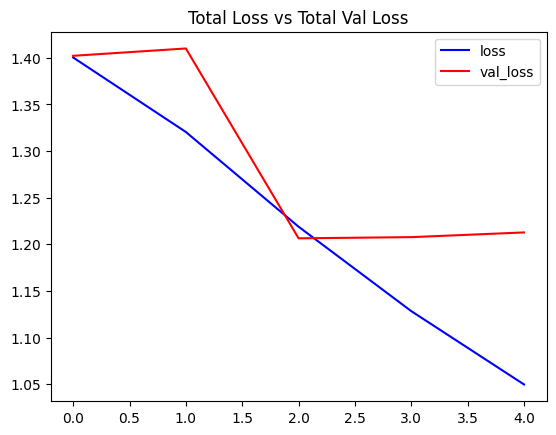

In [59]:
plot_metric(LRCN_model_training_history,'loss','val_loss','Total Loss vs Total Val Loss')

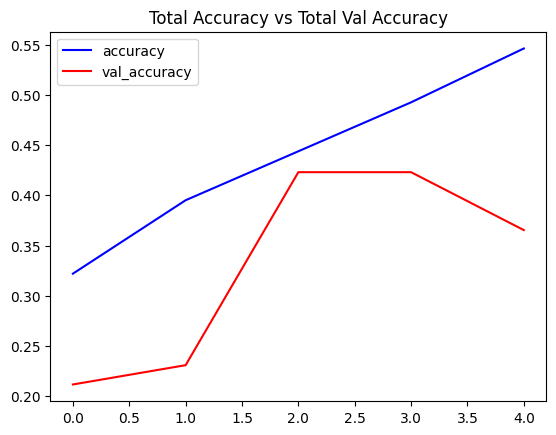

In [60]:
plot_metric(LRCN_model_training_history,'accuracy','val_accuracy','Total Accuracy vs Total Val Accuracy')

# TESTING

In [61]:
!pip install moviepy

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 9.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 61.1 MB/s eta 0:00:00:00:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110721 sha256=4ee3123b49886c99647adadaa9c86b18ce8b00209af62845fe3bc488aa4b7c53
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [64]:
import os

from moviepy.editor import VideoFileClip

test_videos_directory='test_videos'

os.makedirs(test_videos_directory,exist_ok=True)





input_video_file_path = '/kaggle/input/ucf101-action-recognition/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi'





video_title = os.path.splitext(os.path.basename(input_video_file_path))[0]





print(f"Video Name: {video_title}")



# This extracts the filename (including extension) from the provided input_video_file_path.

# os.path.splitext(...):



# This splits the filename and extension. It returns a tuple where the first element is the filename without the extension, and the second element is the extension.

# [0]:



# This selects the first element of the tuple, which is the filename without the extension.




Video Name: v_ApplyEyeMakeup_g01_c01


In [66]:


# def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):

#     video_reader = cv2.VideoCapture(video_file_path)



#     original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

#     original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))



#     video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),

#                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))



#     frames_queue = deque(maxlen=SEQUENCE_LENGTH)



#     predicted_class_name = ''



#     while video_reader.isOpened():

#         ok, frame = video_reader.read()

#         if not ok:

#             break  # Exit the loop when there are no more frames



#         # Check if the frame is empty before resizing

#         if not frame.size:

#             continue



#         resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

#         normalized_frame = resized_frame / 255

#         frames_queue.append(normalized_frame)



#         if len(frames_queue) == SEQUENCE_LENGTH:

#             predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]

#             predicted_label = np.argmax(predicted_labels_probabilities)



#             predicted_class_name = CLASSES_LIST[predicted_label]



#             cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

#             video_writer.write(frame)



#     video_reader.release()

#     video_writer.release()


Here, np.expand_dims(frames_queue, axis=0) is used to add an extra dimension to the frames_queue array along axis 0. This is necessary because the predict method of the LRCN model expects a batch of inputs, and the added dimension represents the batch size. The resulting array has the shape (1, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), where CHANNELS is the number of color channels in the frames (e.g., 3 for RGB).



After obtaining the predictions using LRCN_model.predict(...), [0] is used to index into the array and retrieve the predictions for the first (and only) sample in the batch.

In [86]:
import cv2
import numpy as np
from collections import deque
from moviepy.editor import VideoFileClip

def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)

    # Retrieve video properties or set defaults
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video_reader.get(cv2.CAP_PROP_FPS) or 24  # Set default fps if None

    # Initialize video writer with a compatible codec
    video_writer = cv2.VideoWriter(output_file_path, 
                                   cv2.VideoWriter_fourcc(*'mp4v'), 
                                   fps, 
                                   (original_video_width, original_video_height))

    if not video_writer.isOpened():
        print("Error: VideoWriter could not be opened.")
        return

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break  # Exit the loop when there are no more frames

        # Skip processing if the frame is empty
        if frame is None or not frame.size:
            continue

        # Preprocess the frame
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_queue.append(normalized_frame)

        # Perform prediction when enough frames are gathered
        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

            # Overlay the prediction on the frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Write the frame with overlay to the output video
        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

    print(f"Processed video saved at {output_file_path}")


# Assuming the rest of your code is unchanged...
output_dir = "/kaggle/working/"
output_video_file_path = f'{output_dir}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Load and display processed video with moviepy
processed_video = VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [88]:
# Check if the clip has an fps attribute, and set it manually if not
if processed_video.fps is None:
    fps_value = 24  # Or any appropriate fps value
else:
    fps_value = processed_video.fps

# Write the video file with the correct fps
processed_video.write_videofile(output_video_file_path, fps=fps_value)


Moviepy - Building video /kaggle/working//v_ApplyEyeMakeup_g03_c02-Output-SeqLen20.mp4.
Moviepy - Writing video /kaggle/working//v_ApplyEyeMakeup_g03_c02-Output-SeqLen20.mp4



TypeError: must be real number, not NoneType